Здесь протестируем и отдебажим готовые классы и функции для создания круговых диаграмм для изображения, а также круговой диаграммы агента и взаимодействия с ними.

Сначала проверим, работает ли всё, что нужно вообще, а потом уже будем тестировать на конкретных кейсах.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2

# 1
from openstreetmap_load_data import find_objects_bounds, load_data_from_openstreetmap
from utils import calculate_right_top_coordinates
from google_api_load_data import load_prepare_and_cut_image
from osm_object import One_OSM_object, Image_OSM_object

# 2, 3
from circle_diagram import Image_circle_diagrams, Agent_circle_diagram, calculate_sectors_count, create_circle_diagram

# 4
from circle_diagram import select_minimum_penalty_element_grid

# tests
from rectangles_drawing import calculate_one_pixels_diffs, draw_all_rectangles

**1. Загружаем картинку и формируем из неё Image_OSM_object**

In [2]:
left_bottom_lat = 54.4081
left_bottom_lon = 48.980
right_top_lat, right_top_lon = calculate_right_top_coordinates(left_bottom_lat, left_bottom_lon)

datafile_name = "tmp.json"

load_data_from_openstreetmap(left_bottom_lat, left_bottom_lon, right_top_lat, right_top_lon, datafile_name)
bounds, tags = find_objects_bounds(datafile_name, right_top_lat, right_top_lon, left_bottom_lat, left_bottom_lon)

img_cutted_satellite = load_prepare_and_cut_image(left_bottom_lat=left_bottom_lat, left_bottom_lon=left_bottom_lon,
                                                  right_top_lat=right_top_lat, right_top_lon=right_top_lon,
                                                  is_debug=False)

In [3]:
img_osm_1 = Image_OSM_object(img_cutted_satellite.shape, right_top_lat, right_top_lon,
                             left_bottom_lat, left_bottom_lon, bounds, tags)

In [4]:
# Один из объектов на изображении
img_osm_1.osm_objects[0].print_osm_object()

maxlat: 25, minlat: 40, maxlon: 116, minlon: 84


**2. Создаём множество круговых диаграмм для всего изображения**

In [5]:
bigger_side_blocks_count = 10

sectors_count = calculate_sectors_count(bigger_side_blocks_count)
print("Sectors count:", sectors_count)

Sectors count: 1018


In [6]:
img_cd = Image_circle_diagrams(img_osm_1, bigger_side_blocks_count, sectors_count)

**3. Создаём круговую диаграмму агента**

In [7]:
agent_cd = Agent_circle_diagram(sectors_count)

In [8]:
agent_cd.insert(50, 60, 2, 'water')
agent_cd.insert(30, 60, 1, 'wood')
agent_cd.insert(100, 120, 1, 'water')
agent_cd.insert(65, 90, 1, 'water')

agent_cd.resort_sectors()

**4. Определим наиболее вероятный элемент сетки на изображении, в котором находится агент**

In [9]:
%%time
center_point, index = select_minimum_penalty_element_grid(img_cd, agent_cd)

Wall time: 2min 10s


In [10]:
print(center_point)
print(index)

[(20.0, 380.0)]
[9]


Итак, отдебажили, теперь работает, но неизвестно, правильно ли, попробуем это выяснить.

## Тесты

In [2]:
def load_all_image_info(left_bottom_lat, left_bottom_lon, data_path, image_path, load_from_net=False):
    right_top_lat, right_top_lon = calculate_right_top_coordinates(left_bottom_lat, left_bottom_lon)
    
    if load_from_net:
        load_data_from_openstreetmap(left_bottom_lat, left_bottom_lon, right_top_lat, right_top_lon, data_path)
        img_cutted_satellite = load_prepare_and_cut_image(left_bottom_lat=left_bottom_lat, left_bottom_lon=left_bottom_lon,
                                                      right_top_lat=right_top_lat, right_top_lon=right_top_lon,
                                                      is_debug=False)
        cv2.imwrite(image_path, img_cutted_satellite)
        
    bounds, tags = find_objects_bounds(data_path, right_top_lat, right_top_lon, left_bottom_lat, left_bottom_lon)
    
    img_cutted_satellite = cv2.imread(image_path)
    
    return img_cutted_satellite, bounds, tags, right_top_lat, right_top_lon

In [3]:
left_bottom_lat = 54.3
left_bottom_lon = 48.6
bigger_side_blocks_count = 10

img_cutted_satellite, bounds, tags, right_top_lat, right_top_lon = load_all_image_info(
    left_bottom_lat=left_bottom_lat, left_bottom_lon=left_bottom_lon, data_path="jsons/42.json", image_path="images/42.png")

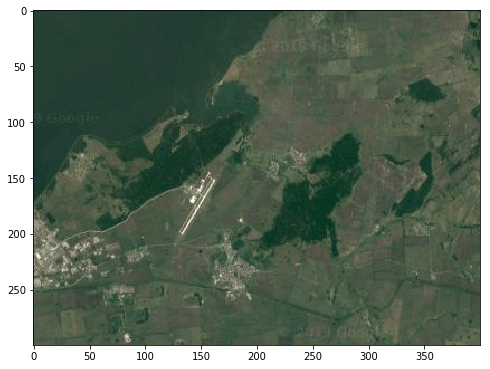

In [4]:
plt.figure(figsize=(8, 10))
plt.imshow(cv2.cvtColor(img_cutted_satellite, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
def create_diagrams(left_bottom_lat, left_bottom_lon, right_top_lat, right_top_lon, bounds, tags, bigger_side_blocks_count,
                   agent_point):
    img_osm = Image_OSM_object(img_cutted_satellite.shape, right_top_lat, right_top_lon,
                             left_bottom_lat, left_bottom_lon, bounds, tags)
    sectors_count = calculate_sectors_count(bigger_side_blocks_count)
    
    img_cd = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count)
    agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm)
    
    return img_cd, agent_cd

In [6]:
img_cd, agent_cd = create_diagrams(left_bottom_lat, left_bottom_lon, right_top_lat, right_top_lon, bounds, tags, 
                                   bigger_side_blocks_count, (120, 120))

C:\Users\vruch\DATA\MIPT\Masters\Diploma\utils.py:38: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(scalar_product / (norm_1 * norm_2)))


In [7]:
img_cd.circle_diagrams[0].sectors

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [(19.79898987322333, 'wood')],
 [(19.79898987322333, 'wood')],
 [(19.79898987322333, 'wood')],
 [(19.79898987322333, 'wood')],
 [(19.79898987322333, 'wood')],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],


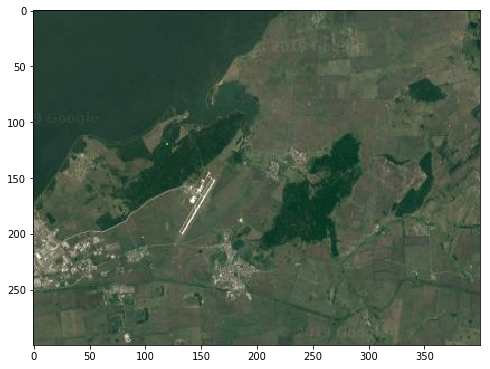

In [8]:
agent_point = (120, 120)
img_cutted_satellite[agent_point[0] - 1: agent_point[0] + 1, agent_point[1] - 1 : agent_point[1] + 1] = [[0, 255, 0] for _ in range(2)]
plt.figure(figsize=(8, 10))
plt.imshow(cv2.cvtColor(img_cutted_satellite, cv2.COLOR_BGR2RGB))
plt.show()

0 water
1 water
2 water
3 water
4 water
5 water
6 water
7 water
8 water
9 water
10 water
11 water
12 water
13 water
14 water
15 water
16 water
17 water
18 water
19 water
20 water
21 water
22 water
23 water
24 water
25 water
26 water
27 water
28 water
29 water
30 water
31 water
32 water
33 water
34 water
35 water
36 water
37 water
38 water
39 water
40 water
41 water
42 water
43 water
44 water
45 water
46 water
47 water
48 water
49 water
50 water
51 water
52 water
53 wood
54 wood
55 wood
56 wood
57 wood
58 wood
59 wood
60 wood
61 wood
62 wood
63 wood
64 wood
65 wood
66 wood
67 wood
68 wood
69 wood
70 wood
71 wood
72 wood
73 wood
74 wood
75 wood
76 wood
77 wood
78 wood
79 wood
80 wood
81 wood
82 wood
83 wood
84 wood
85 wood
86 wood
87 wood
88 wood
89 wood
90 wood
91 wood
92 wood
93 wood
94 wood
95 wood
96 wood
97 wood
98 wood
99 wood
100 wood
101 wood
102 wood
103 wood
104 wood
105 wood
106 wood
107 wood
108 wood
109 wood
110 wood
111 wood
112 wood
113 wood
114 wood
115 wood
116 wood
117 

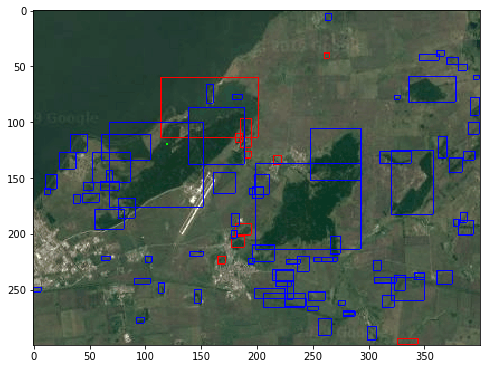

In [9]:
one_pixel_lat_diff, one_pixel_lon_diff = calculate_one_pixels_diffs(right_top_lat, right_top_lon,
                                                                    left_bottom_lat, left_bottom_lon,
                                                                    img_cutted_satellite.shape)
img_result = draw_all_rectangles(img_cutted_satellite, bounds, tags,
                                 right_top_lat, right_top_lon, left_bottom_lat, left_bottom_lon,
                                 one_pixel_lat_diff, one_pixel_lon_diff)
plt.figure(figsize=(8, 10))
plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
plt.show()

In [10]:
# Пока круговая диаграмма агента выглядит довольно формально, потом её подкорректируем
agent_cd.sectors

[[(56.85068161420758, 'wood'),
  (98.29038610159185, 'wood'),
  (105.3612832116238, 'wood'),
  (144.69277798148738, 'water'),
  (150.81445554057476, 'wood')],
 [(56.85068161420758, 'wood'),
  (98.29038610159185, 'wood'),
  (105.3612832116238, 'wood'),
  (144.69277798148738, 'water'),
  (150.81445554057476, 'wood')],
 [(56.85068161420758, 'wood'),
  (98.29038610159185, 'wood'),
  (105.3612832116238, 'wood'),
  (144.69277798148738, 'water'),
  (150.81445554057476, 'wood')],
 [(56.85068161420758, 'wood'),
  (98.29038610159185, 'wood'),
  (105.3612832116238, 'wood'),
  (144.69277798148738, 'water'),
  (150.81445554057476, 'wood')],
 [(56.85068161420758, 'wood'),
  (98.29038610159185, 'wood'),
  (105.3612832116238, 'wood'),
  (144.69277798148738, 'water'),
  (159.81239000778382, 'water')],
 [(56.85068161420758, 'wood'),
  (98.29038610159185, 'wood'),
  (105.3612832116238, 'wood'),
  (144.69277798148738, 'water'),
  (154.85799947048264, 'wood'),
  (159.81239000778382, 'water')],
 [(56.850681

In [11]:
%%time
center_points, indexes = select_minimum_penalty_element_grid(img_cd, agent_cd)
print(center_points)
print(indexes)

[(140.0, 100.0)]
[32]
Wall time: 4min 16s


In [35]:
# Теперь нарисуем на изображении прямоугольник, соответствующий определённому элементу сетки

In [12]:
bigger_side = max(img_cutted_satellite.shape[0], img_cutted_satellite.shape[1])
one_block_len = bigger_side / bigger_side_blocks_count
print(one_block_len)
half = one_block_len / 2

40.0


In [13]:
center_point = center_points[0]
(int(center_point[1] - half), int(center_point[0] - half))

(80, 120)

In [14]:
(int(center_point[0] + half), int(center_point[1] + half))

(160, 120)

In [15]:
half

20.0

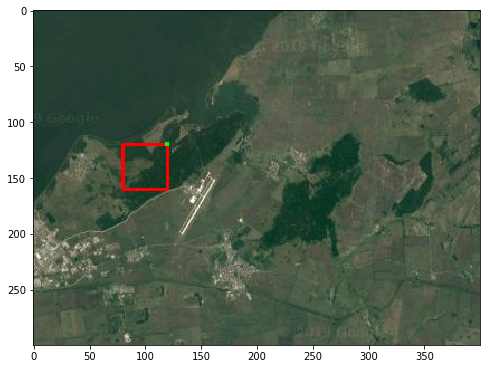

In [16]:
img_result_show = img_cutted_satellite.copy()

for center_point in center_points:
    cv2.rectangle(img_result_show,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), (0, 0, 255), 2)
img_result_show[agent_point[0] - 2: agent_point[0] + 2, agent_point[1] - 2 : agent_point[1] + 2] = [[0, 255, 0] for _ in range(4)]

plt.figure(figsize=(8, 10))
plt.imshow(cv2.cvtColor(img_result_show, cv2.COLOR_BGR2RGB))
plt.show()

In [17]:
# Надо теперь разобраться, почему так получилось... Почему квадрат оказался не тот

In [8]:
from circle_diagram import calculate_penalty_for_diagrams

In [9]:
def select_minimum_penalty_element_grid(img_cds, agent_cd):
    """
    img_cds - объект класса Image_circle_diagrams
    agent_cd - объект класса Agent_circle_diagram
    """
    center_points = []
    penalties = []
    
    for i in range(len(img_cds.center_points)):
        center_point = img_cds.center_points[i]
        print(center_point)
        img_cd = img_cds.circle_diagrams[i]
        
        cur_cd_penalties = []
        
        for j in range(len(agent_cd.sectors)):
            cur_cd_penalties.append(calculate_penalty_for_diagrams(img_cd.sectors, agent_cd.sectors))
            agent_cd.rotate()
        penalties.append(min(cur_cd_penalties))
        center_points.append(center_point)
    
    
    minimum_penalty = min(penalties)
    print(minimum_penalty)
    # Вернём список из всех центров элементов сетки, которым соответствует минимальный штраф
    
    center_points_minimum_penalty = []
    indices_minimum_penalty = []
    
    for i in range(len(penalties)):
        if penalties[i] == minimum_penalty:
            center_points_minimum_penalty.append(center_points[i])
            indices_minimum_penalty.append(i)
    
    print(penalties)
    
    return center_points_minimum_penalty, indices_minimum_penalty, penalties

In [27]:
%%time
center_points, indices, all_penalties = select_minimum_penalty_element_grid(img_cd, agent_cd)

(20.0, 20.0)
(20.0, 60.0)
(20.0, 100.0)
(20.0, 140.0)
(20.0, 180.0)
(20.0, 220.0)
(20.0, 260.0)
(20.0, 300.0)
(20.0, 340.0)
(20.0, 380.0)
(60.0, 20.0)
(60.0, 60.0)
(60.0, 100.0)
(60.0, 140.0)
(60.0, 180.0)
(60.0, 220.0)
(60.0, 260.0)
(60.0, 300.0)
(60.0, 340.0)
(60.0, 380.0)
(100.0, 20.0)
(100.0, 60.0)
(100.0, 100.0)
(100.0, 140.0)
(100.0, 180.0)
(100.0, 220.0)
(100.0, 260.0)
(100.0, 300.0)
(100.0, 340.0)
(100.0, 380.0)
(140.0, 20.0)
(140.0, 60.0)
(140.0, 100.0)
(140.0, 140.0)
(140.0, 180.0)
(140.0, 220.0)
(140.0, 260.0)
(140.0, 300.0)
(140.0, 340.0)
(140.0, 380.0)
(180.0, 20.0)
(180.0, 60.0)
(180.0, 100.0)
(180.0, 140.0)
(180.0, 180.0)
(180.0, 220.0)
(180.0, 260.0)
(180.0, 300.0)
(180.0, 340.0)
(180.0, 380.0)
(220.0, 20.0)
(220.0, 60.0)
(220.0, 100.0)
(220.0, 140.0)
(220.0, 180.0)
(220.0, 220.0)
(220.0, 260.0)
(220.0, 300.0)
(220.0, 340.0)
(220.0, 380.0)
(260.0, 20.0)
(260.0, 60.0)
(260.0, 100.0)
(260.0, 140.0)
(260.0, 180.0)
(260.0, 220.0)
(260.0, 260.0)
(260.0, 300.0)
(260.0, 340.0)

**Тепловая карта**

In [30]:
img_cd.center_points

[(20.0, 20.0),
 (20.0, 60.0),
 (20.0, 100.0),
 (20.0, 140.0),
 (20.0, 180.0),
 (20.0, 220.0),
 (20.0, 260.0),
 (20.0, 300.0),
 (20.0, 340.0),
 (20.0, 380.0),
 (60.0, 20.0),
 (60.0, 60.0),
 (60.0, 100.0),
 (60.0, 140.0),
 (60.0, 180.0),
 (60.0, 220.0),
 (60.0, 260.0),
 (60.0, 300.0),
 (60.0, 340.0),
 (60.0, 380.0),
 (100.0, 20.0),
 (100.0, 60.0),
 (100.0, 100.0),
 (100.0, 140.0),
 (100.0, 180.0),
 (100.0, 220.0),
 (100.0, 260.0),
 (100.0, 300.0),
 (100.0, 340.0),
 (100.0, 380.0),
 (140.0, 20.0),
 (140.0, 60.0),
 (140.0, 100.0),
 (140.0, 140.0),
 (140.0, 180.0),
 (140.0, 220.0),
 (140.0, 260.0),
 (140.0, 300.0),
 (140.0, 340.0),
 (140.0, 380.0),
 (180.0, 20.0),
 (180.0, 60.0),
 (180.0, 100.0),
 (180.0, 140.0),
 (180.0, 180.0),
 (180.0, 220.0),
 (180.0, 260.0),
 (180.0, 300.0),
 (180.0, 340.0),
 (180.0, 380.0),
 (220.0, 20.0),
 (220.0, 60.0),
 (220.0, 100.0),
 (220.0, 140.0),
 (220.0, 180.0),
 (220.0, 220.0),
 (220.0, 260.0),
 (220.0, 300.0),
 (220.0, 340.0),
 (220.0, 380.0),
 (260.0, 20.

In [33]:
all_penalties_reshaped = np.array(all_penalties).reshape(int(len(all_penalties) / bigger_side_blocks_count),
                                                         bigger_side_blocks_count)
print(all_penalties_reshaped)

[[ 918.66953669  881.53296025  949.22264592 1027.71331886 1012.52646942
   898.65424617  811.40086528  800.01224283  828.10978205  892.22094184]
 [ 862.4251938   799.51915443  821.09163112  952.128397    911.64928322
   827.25985543  732.15921825  670.4005092   562.70845247  490.2982332 ]
 [ 801.47835269  594.80997766  452.18210229  357.68337505  635.68360215
   566.74932555  582.47389408  564.37960884  580.28038643  526.25383878]
 [ 612.68793411  502.13378308  327.36215866  429.10042144  356.36890022
   555.60531179  508.70813224  508.67765872  520.61360418  476.72755608]
 [ 706.4336611   518.83559095  472.90443776  541.3833905   576.49458721
   549.85936366  558.12514676  508.55481481  499.16456441  528.29629382]
 [ 789.46757117  581.97630369  489.45660115  609.5666054   494.58467591
   541.66167312  517.93043776  584.45310311  493.95649612  568.48654604]
 [ 828.24303429  803.31625323  741.80677022  628.71442271  611.89605725
   481.42258937  519.57323092  416.53522484  478.6044129  

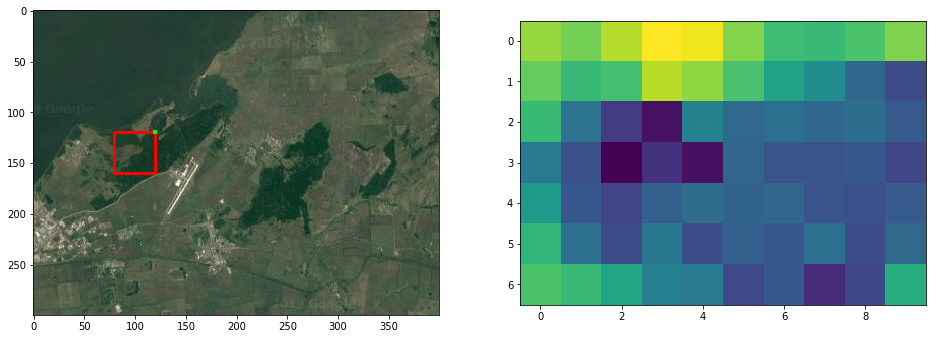

In [40]:
plt.figure(figsize=(16, 20))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_result_show, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(all_penalties_reshaped)
plt.show()

Теперь посмотрим, что в случае с крупной сеткой

In [10]:
left_bottom_lat = 54.3
left_bottom_lon = 48.6
bigger_side_blocks_count = 4

img_cutted_satellite, bounds, tags, right_top_lat, right_top_lon = load_all_image_info(
    left_bottom_lat=left_bottom_lat, left_bottom_lon=left_bottom_lon, data_path="jsons/42.json", image_path="images/42.png")

In [11]:
img_cd, agent_cd = create_diagrams(left_bottom_lat, left_bottom_lon, right_top_lat, right_top_lon, bounds, tags, 
                                   bigger_side_blocks_count, (120, 120))

In [12]:
%%time
center_points, indexes, all_penalties = select_minimum_penalty_element_grid(img_cd, agent_cd)
print(center_points)
print(indexes)

(50.0, 50.0)
(50.0, 150.0)
(50.0, 250.0)
(50.0, 350.0)
(150.0, 50.0)
(150.0, 150.0)
(150.0, 250.0)
(150.0, 350.0)
(250.0, 50.0)
(250.0, 150.0)
(250.0, 250.0)
(250.0, 350.0)
44.8714045993282
[94.33156121250974, 109.29839106437181, 78.92049840917302, 58.691945908406154, 53.06079506461294, 49.8825346536083, 57.05294791713666, 52.8496012434372, 89.24797834406104, 65.74706612847075, 60.96911266213009, 44.8714045993282]
[(250.0, 350.0)]
[11]
Wall time: 498 ms


100.0


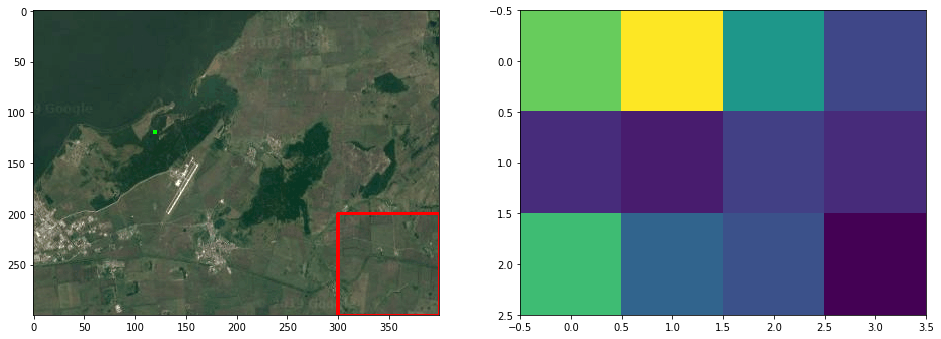

In [14]:
agent_point = (120, 120)

bigger_side = max(img_cutted_satellite.shape[0], img_cutted_satellite.shape[1])
one_block_len = bigger_side / bigger_side_blocks_count
print(one_block_len)
half = one_block_len / 2

all_penalties_reshaped = np.array(all_penalties).reshape(int(len(all_penalties) / bigger_side_blocks_count),
                                                         bigger_side_blocks_count)

img_result_show = img_cutted_satellite.copy()

for center_point in center_points:
    cv2.rectangle(img_result_show,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), (0, 0, 255), 2)
img_result_show[agent_point[0] - 2: agent_point[0] + 2,
                agent_point[1] - 2 : agent_point[1] + 2] = [[0, 255, 0] for _ in range(4)]

plt.figure(figsize=(16, 20))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_result_show, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(all_penalties_reshaped)
plt.show()

Ну и с очень мелкой

In [15]:
left_bottom_lat = 54.3
left_bottom_lon = 48.6
bigger_side_blocks_count = 5

img_cutted_satellite, bounds, tags, right_top_lat, right_top_lon = load_all_image_info(
    left_bottom_lat=left_bottom_lat, left_bottom_lon=left_bottom_lon, data_path="jsons/42.json", image_path="images/42.png")

In [16]:
img_cd, agent_cd = create_diagrams(left_bottom_lat, left_bottom_lon, right_top_lat, right_top_lon, bounds, tags, 
                                   bigger_side_blocks_count, (120, 120))

AssertionError: 

In [6]:
300 / 80

3.75

In [8]:
%%time
center_points, indexes, all_penalties = select_minimum_penalty_element_grid(img_cd, agent_cd)
print(center_points)

print(indexes)

(40.0, 40.0)
(40.0, 120.0)
(40.0, 200.0)
(40.0, 280.0)
(40.0, 360.0)
(120.0, 40.0)
(120.0, 120.0)
(120.0, 200.0)
(120.0, 280.0)
(120.0, 360.0)
(200.0, 40.0)
(200.0, 120.0)
(200.0, 200.0)
(200.0, 280.0)
(200.0, 360.0)
0.0
[171.0538105856715, 186.01203221069568, 179.7118906413888, 156.25842178200554, 105.5533402578898, 89.78276327261668, 0.0, 91.10184256736893, 101.05666923801257, 103.73801014019905, 134.09583142535539, 103.92978945794012, 110.94523920380122, 110.03917501886787, 99.10920934741412]
[(120.0, 120.0)]
[6]
Wall time: 1.85 s


80.0


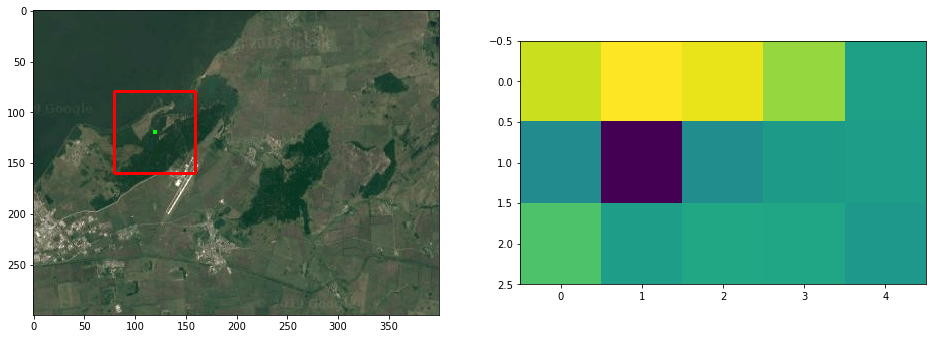

In [10]:
agent_point = (120, 120)

bigger_side = max(img_cutted_satellite.shape[0], img_cutted_satellite.shape[1])
one_block_len = bigger_side / bigger_side_blocks_count
print(one_block_len)
half = one_block_len / 2

all_penalties_reshaped = np.array(all_penalties).reshape(int(len(all_penalties) / bigger_side_blocks_count),
                                                         bigger_side_blocks_count)

img_result_show = img_cutted_satellite.copy()

for center_point in center_points:
    cv2.rectangle(img_result_show,
                 (int(center_point[1] - half), int(center_point[0] - half)),
                 (int(center_point[1] + half), int(center_point[0] + half)), (0, 0, 255), 2)
img_result_show[agent_point[0] - 2: agent_point[0] + 2,
                agent_point[1] - 2 : agent_point[1] + 2] = [[0, 255, 0] for _ in range(4)]

plt.figure(figsize=(16, 20))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_result_show, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(all_penalties_reshaped)
plt.show()

Можно по принципу softmax добавить вероятности и возвращать top n ячеек, в которые с наибольшей вероятностью попадает агент, а можно так не делать.
Пока не понятно, как это будет сочетаться с точностью детектора.

In [11]:
# По вертикали почему-то разбиение получилось не полным
img_cd.center_points

[(40.0, 40.0),
 (40.0, 120.0),
 (40.0, 200.0),
 (40.0, 280.0),
 (40.0, 360.0),
 (120.0, 40.0),
 (120.0, 120.0),
 (120.0, 200.0),
 (120.0, 280.0),
 (120.0, 360.0),
 (200.0, 40.0),
 (200.0, 120.0),
 (200.0, 200.0),
 (200.0, 280.0),
 (200.0, 360.0)]

In [16]:
300 / 5

60.0